In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download data

In [2]:
!curl -O "https://raw.githubusercontent.com/SaminRK/scPSS-reproducibility/refs/heads/master/data_downloaders/download_hlca_tutorial.py"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   927  100   927    0     0   5872      0 --:--:-- --:--:-- --:--:--  5904


In [3]:
from download_hlca_tutorial import download_hlca_tutorial

download_hlca_tutorial("data/")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1wWGwbPeap-IqWNVlwVVUWVrUAMrf45ye
From (redirected): https://drive.google.com/uc?export=download&id=1wWGwbPeap-IqWNVlwVVUWVrUAMrf45ye&confirm=t&uuid=92806385-686d-4d7f-a75a-d7bb1be7bb21
To: /content/hlca_tutorial.h5ad
100%|██████████| 118M/118M [00:01<00:00, 73.7MB/s]


## Use scPSS

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install git+https://github.com/SaminRK/scPSS.git

  Cloning https://github.com/SaminRK/scPSS.git to /tmp/pip-req-build-xq2d9do6
  Running command git clone --filter=blob:none --quiet https://github.com/SaminRK/scPSS.git /tmp/pip-req-build-xq2d9do6
  Resolved https://github.com/SaminRK/scPSS.git to commit c16c71713e6a618ed6196b83b1dc3daa30838e1a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of umap-learn to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 136.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.4 MB/s eta 0:00:00
  Created wheel for scPSS: f

In [6]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
ad_total = sc.read('/content/data/hlca_tutorial.h5ad')

## Explore each cell type separately

## Problem scenario: Only healthy reference available

In [ ]:
ad_normal = ad_total[ad_total.obs['disease'] == 'normal']
ad_disease = ad_total[ad_total.obs['disease'] == 'pulmonary fibrosis']

In [ ]:
DONOR_KEY = 'donor_id'

In [ ]:
normal_donor_ids = list(ad_normal.obs[DONOR_KEY].unique())
disease_donor_ids = list(ad_disease.obs[DONOR_KEY].unique())

In [ ]:
def get_upper_limit(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    upper_limit_from_data = q1
    for d in data:
        if d < upper_limit and d > upper_limit_from_data:
            upper_limit_from_data = d

    return upper_limit_from_data

In [ ]:
import random
import scanpy as sc
from scpss import scPSS

def process(ad, seed, celltype):
    random.seed(seed)

    ref_normal_num_donors = len(normal_donor_ids) * 1 // 2
    ref_disease_num_donors = len(disease_donor_ids) * 1 // 2
    ref_normal_donor_ids = random.sample(normal_donor_ids, ref_normal_num_donors)
    que_normal_donor_ids = [s for s in normal_donor_ids if s not in ref_normal_donor_ids]
    ref_disease_donor_ids = random.sample(disease_donor_ids, ref_disease_num_donors)
    que_disease_donor_ids = [s for s in disease_donor_ids if s not in ref_disease_donor_ids]

    que_donor_ids = que_normal_donor_ids + que_disease_donor_ids

    ad_scpss = ad[ad.obs[DONOR_KEY].isin(ref_normal_donor_ids + que_donor_ids)]
    sc.tl.pca(ad_scpss)

    ref_normal_samples = ad_scpss[ad_scpss.obs[DONOR_KEY].isin(ref_normal_donor_ids)].obs['sample'].unique()
    que_samples = ad_scpss[ad_scpss.obs[DONOR_KEY].isin(que_donor_ids)].obs['sample'].unique()

    scpss = scPSS(ad_scpss, 'sample', ref_normal_samples, que_samples)
    scpss.harmony_integrate()
    scpss.find_optimal_parameters(search_ks=np.arange(4, 16))
    params = scpss.best_params
    scpss.set_distance_and_condition()

    outlier_ratio_ref_datasets = []
    outlier_ratio_que_datasets = []

    all_labels = scpss.adata.obs['scpss_outlier']

    for donor in ref_normal_donor_ids:
        labels = all_labels[scpss.adata.obs[DONOR_KEY] == donor]
        if len(labels) > 0: outlier_ratio_ref_datasets.append(np.mean(labels == 'Outlier'))
        else: outlier_ratio_ref_datasets.append(None)

    for donor in que_donor_ids:
        labels = all_labels[scpss.adata.obs[DONOR_KEY] == donor]
        if len(labels) > 0: outlier_ratio_que_datasets.append(np.mean(labels == 'Outlier'))
        else: outlier_ratio_que_datasets.append(None)

    def filter_nones(l):
        return [x for x in l if x is not None]

    outlier_ratio_ref_filtered = filter_nones(outlier_ratio_ref_datasets)
    outlier_ratio_que_filtered = filter_nones(outlier_ratio_que_datasets)

    ratio_limit = get_upper_limit(outlier_ratio_ref_filtered)

    print('Limit:', ratio_limit)

    outlier_ratio_que_healthy_datasets = []
    outlier_ratio_que_disease_datasets = []

    for donor in que_normal_donor_ids:
        labels = all_labels[scpss.adata.obs[DONOR_KEY] == donor]
        if len(labels) > 0: outlier_ratio_que_healthy_datasets.append(np.mean(labels == 'Outlier'))

    for donor in que_disease_donor_ids:
        labels = all_labels[scpss.adata.obs[DONOR_KEY] == donor]
        if len(labels) > 0: outlier_ratio_que_disease_datasets.append(np.mean(labels == 'Outlier'))

    true_labels = [0] * len(outlier_ratio_que_healthy_datasets) + [1] * len(outlier_ratio_que_disease_datasets)
    outlier_ratios = outlier_ratio_que_healthy_datasets + outlier_ratio_que_disease_datasets
    predicted_labels = np.array(outlier_ratios) > ratio_limit

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    my_dict = {
        'reference': outlier_ratio_ref_filtered,
        'healthy': outlier_ratio_que_healthy_datasets,
        'disease': outlier_ratio_que_disease_datasets
    }

    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())

    plt.show()
    plt.close()

    # Create dictionary with the data
    my_dict = {
        'Reference': outlier_ratio_ref_filtered,
        'Query': outlier_ratio_que_healthy_datasets + outlier_ratio_que_disease_datasets
    }

    # Convert dictionary to list for plotting
    data = [my_dict[key] for key in my_dict.keys()]
    quantiles = [[0.25, 0.5, 0.75]] * len(data)

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(4, 3))

    # Create violin plot using plt.violinplot()
    vp = ax.violinplot(data, quantiles=quantiles)

    # Set colors for the violin borders only (removing the fill)
    for body in vp['bodies']:
        body.set_facecolor('none')  # Remove fill color
        body.set_edgecolor('black')  # Set edge color to black
        body.set_linewidth(1.5)      # Adjust line width for visibility

    # Set x-tick labels and fontsize
    ax.set_xticks([1, 2])  # Set the positions of the xticks
    ax.set_xticklabels(my_dict.keys(), fontsize=12)

    # Set y-axis label (optional, change as needed)
    ax.set_ylabel('Disease Ratio', fontsize=12)

    ax.axhline(ratio_limit, color='black', linestyle='--', label='Threshold')
    ax.legend(loc='upper left', fontsize=12)

    # Set tick parameters for y-axis
    ax.tick_params(axis='y', labelsize=12)

    # Adjust layout for a clean look
    plt.tight_layout()

    plt.savefig(f'boxplot_{celltype}_{seed}.svg')

    # Show the plot
    plt.show()
    plt.close()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)


    Dict = {
        'problem': f'healthy-reference-{celltype}-{seed}',
        'n_comps': float(params['n_comps']),
        'optimal_k': float(params['optimal_k']),
        'optimal_p': params['optimal_p'],
        'ratio-limit': ratio_limit,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'outlier_ratio_ref_datasets': outlier_ratio_ref_datasets,
        'outlier_ratio_que_datasets': outlier_ratio_que_datasets,
        'ref_normal_samples': ref_normal_donor_ids,
        'que_normal_samples': que_normal_donor_ids,
        'que_disease_samples': que_disease_donor_ids,
        'que_samples': que_donor_ids,
    }

    return Dict

In [ ]:
OUTPUT_PATH = "/content/drive/MyDrive/Research - Sohel sir/Pathological Cells/Pathological Cell Identification/reproducibility/scpss_data"

In [12]:
celltypes = [
    "Macrophages",
    "T cell lineage",
    "Secretory",
    "Multiciliated lineage",
    "Monocytes",
    "Lymphatic EC mature",
    "B cell lineage",
    "AT2",
    "Innate lymphoid cell NK",
    "EC arterial",
    "Basal",
    "EC venous",
    "Fibroblasts",
    "AT1",
    "Mast cells",
    "Myofibroblasts",
]

In [ ]:
import json
import os

for celltype in celltypes:
    print('Processing celltype:', celltype)
    os.makedirs(f"{OUTPUT_PATH}/scpss-problem-1", exist_ok=True)
    os.makedirs(f"{OUTPUT_PATH}/scpss-problem-1/{celltype}", exist_ok=True)

    ad = ad_total[ad_total.obs['ann_level_3_label_final'] == celltype]

    SAMPLE_SIZE = 100_000
    if len(ad) > SAMPLE_SIZE: sc.pp.subsample(ad, n_obs=SAMPLE_SIZE)

    for i in range(10):
        try:
            print('==>', i)
            seed = i * 100
            Dict = process(ad, seed, celltype)
            json.dump(Dict, open(f"{OUTPUT_PATH}/scpss-problem-1/{celltype}/{seed}.json", 'w'), indent=4)
        except:
            pass

Output hidden; open in https://colab.research.google.com to view.

## Integrate pathological scores of cells from each cell type to determine condition of individual

In [13]:
import json

In [14]:
PATH = "/content/drive/MyDrive/Research - Sohel sir/Pathological Cells/Pathological Cell Identification/reproducibility/scpss_data/scpss-problem-1"

In [15]:
celltypes = [
    "Macrophages",
    "T cell lineage",
    "Secretory",
    "Multiciliated lineage",
    "Monocytes",
    "Lymphatic EC mature",
    "B cell lineage",
    "AT2",
    "Innate lymphoid cell NK",
    "EC arterial",
    "Basal",
    "EC venous",
    "Fibroblasts",
    "AT1",
    "Mast cells",
    "Myofibroblasts",
]

In [16]:
my_dict = {}
for celltype in celltypes:
    try:
        dicts = []
        for i in range(10):
            fp = f"{PATH}/{celltype}/{i*100}.json"
            with open(fp, 'r') as file:
                data = json.load(file)
            dicts.append(data)
        accs = [d['accuracy'] for d in dicts]
        my_dict[celltype] = accs
    except:
        pass

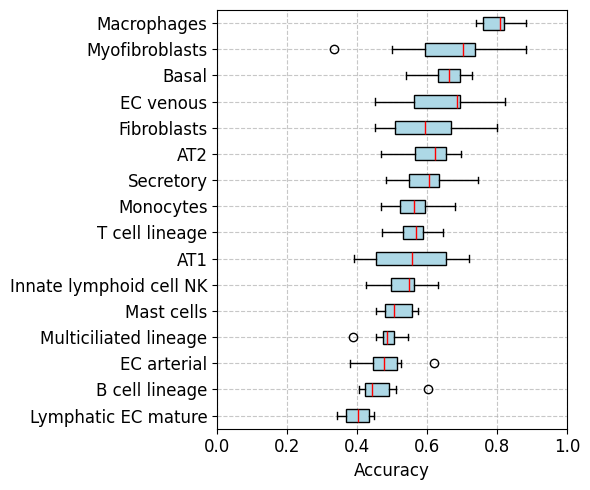

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the dictionary by the mean of the values
sorted_dict = {k: v for k, v in sorted(my_dict.items(), key=lambda item: np.mean(item[1]))}

# Define figure size for better readability
fig, ax = plt.subplots(figsize=(6, 5))

# Create a horizontal box plot with sorted values
ax.boxplot(sorted_dict.values(), vert=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           medianprops=dict(color='red'))

# Set y-axis labels with sorted keys
ax.set_yticklabels(sorted_dict.keys(), fontsize=12)

# Set x-axis label with larger font size
ax.set_xlabel('Accuracy', fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase tick label size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.xlim([0, 1])

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [18]:
for celltype in celltypes:
    print(celltype, np.median(sorted_dict[celltype]), np.mean(sorted_dict[celltype]))

Macrophages 0.8082107843137255 0.8019436095508438
T cell lineage 0.5686274509803921 0.562520988075927
Secretory 0.6055555555555556 0.5996849446849446
Multiciliated lineage 0.4861952861952862 0.48599008957499523
Monocytes 0.5627442466348241 0.5657073398276979
Lymphatic EC mature 0.4023809523809524 0.4004656944591864
B cell lineage 0.4432397959183674 0.4644024099001302
AT2 0.6236111111111111 0.6035846261922193
Innate lymphoid cell NK 0.5487804878048781 0.5363472458922344
EC arterial 0.47673160173160173 0.4831431500006298
Basal 0.6633333333333333 0.6563195047249668
EC venous 0.6859078590785908 0.6483785772594375
Fibroblasts 0.5957070707070706 0.6074169823999659
AT1 0.5564024390243902 0.5563406441556898
Mast cells 0.5058139534883721 0.5141214085201155
Myofibroblasts 0.7029411764705882 0.6644248845783373


In [19]:
def get_upper_limit(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    upper_limit_from_data = q1
    for d in data:
        if d < upper_limit and d > upper_limit_from_data:
            upper_limit_from_data = d

    return upper_limit_from_data

In [20]:
def average_labelling(diseased_portion, upper_limits):
    number = 0
    given_sum = 0
    limit_sum = 0
    for k, v in diseased_portion.items():
        if v is not None:
            number += 1
            given_sum += diseased_portion[k]
            limit_sum += upper_limits[k]

    return max(given_sum - limit_sum, 0) > .2

In [21]:
def average_labelling_score(diseased_portion, upper_limits):
    given_sum = 0
    limit_sum = 0
    for k, v in diseased_portion.items():
        if v is not None:
            given_sum += diseased_portion[k]
            limit_sum += upper_limits[k]
    return max(given_sum - limit_sum, 0)

In [22]:
def majority_labelling(disease_portion, upper_limits):
    outlier_vote = 0
    inlier_vote = 0
    for k, v in disease_portion.items():
        if v is not None:
            if disease_portion[k] > upper_limits[k]:
                outlier_vote += 1
            else:
                inlier_vote += 1
    return outlier_vote >= inlier_vote

In [23]:
def atleast_n_outlier_labelling(disease_portion, upper_limits, n=2):
    outlier_vote = 0
    inlier_vote = 0
    for k, v in disease_portion.items():
        if v is not None:
            if disease_portion[k] > upper_limits[k]:
                outlier_vote += 1
            else:
                inlier_vote += 1
    return outlier_vote >= n

In [24]:
def priority_labelling(disease_portion, upper_limits):
    for celltype in ('Macrophages', 'EC venous', 'AT2'):
        if disease_portion[celltype] is not None:
            return disease_portion[celltype] > upper_limits[celltype]
    return False

In [25]:
def adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.15):
    number = 0
    given_sum = 0
    limit_sum = 0
    for k, v in disease_portion.items():
        if v is not None:
            number += 1
            if disease_portion[k] >= upper_limits[k]:
                given_sum += (1 - inlier_weight) * (disease_portion[k] - upper_limits[k]) / (1 - upper_limits[k])
            else:
                given_sum += inlier_weight * (disease_portion[k] - upper_limits[k]) / upper_limits[k]
    return number != 0 and given_sum > 0.1

In [26]:
def adjusted_average_labelling_score(disease_portion, upper_limits, inlier_weight=.2):
    number = 0
    given_sum = 0
    limit_sum = 0
    for k, v in disease_portion.items():
        if v is not None:
            number += 1
            if disease_portion[k] > upper_limits[k]:
                given_sum += (1 - inlier_weight) * (disease_portion[k] - upper_limits[k]) / (1 - upper_limits[k])
            else:
                given_sum += inlier_weight * (disease_portion[k] - upper_limits[k]) / upper_limits[k]
    return given_sum

## All combos

In [28]:
celltypes = [
    "Macrophages",
    "AT2",
    "Basal",
    "EC venous",
    "Fibroblasts",
]

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def get_acc_for_test_id(id=0, labelling_fn=average_labelling, verbose=False):
    dict_of_dicts = {}

    for celltype in celltypes:
        dict_of_dicts[celltype] = json.loads(open(f"{PATH}/{celltype}/{id*100}.json", 'r').read())

    Dict = dict_of_dicts['Macrophages']
    que_samples = Dict['que_samples']
    que_normal_samples = Dict['que_normal_samples']
    que_disease_samples = Dict['que_disease_samples']
    outlier_ratio_que_datasets = Dict['outlier_ratio_que_datasets']
    outlier_ratio_ref_datasets = Dict['outlier_ratio_ref_datasets']

    true_labels = [0] * len(que_normal_samples) + [1] * len(que_disease_samples)

    upper_limits = {}

    def filter_nones(l):
        return [x for x in l if x is not None]

    for celltype in celltypes:
        upper_limits[celltype] = get_upper_limit(filter_nones(dict_of_dicts[celltype]['outlier_ratio_ref_datasets']))

    label = []
    for i, (s, o) in enumerate(zip(que_samples, outlier_ratio_que_datasets)):
        if s in que_normal_samples:
            disease_portion = {}
            for celltype in celltypes:
                disease_portion[celltype] = dict_of_dicts[celltype]['outlier_ratio_que_datasets'][i]
            label.append(labelling_fn(disease_portion, upper_limits))

    for i, (s, o) in enumerate(zip(que_samples, outlier_ratio_que_datasets)):
        if s in que_disease_samples:
            disease_portion = {}
            for celltype in celltypes:
                disease_portion[celltype] = dict_of_dicts[celltype]['outlier_ratio_que_datasets'][i]
            label.append(labelling_fn(disease_portion, upper_limits))

    predicted_labels = label
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    if verbose:
        print(id, accuracy, precision, recall, f1)

    return accuracy, precision, recall, f1, predicted_labels

In [31]:
labelling_algos = {
    'Atleast n=1': lambda disease_portion, upper_limits: atleast_n_outlier_labelling(disease_portion, upper_limits, n=1),
    'Atleast n=2': lambda disease_portion, upper_limits: atleast_n_outlier_labelling(disease_portion, upper_limits, n=2),
    'Atleast n=3': lambda disease_portion, upper_limits: atleast_n_outlier_labelling(disease_portion, upper_limits, n=3),
    'Atleast n=4': lambda disease_portion, upper_limits: atleast_n_outlier_labelling(disease_portion, upper_limits, n=4),
    'Atleast n=5': lambda disease_portion, upper_limits: atleast_n_outlier_labelling(disease_portion, upper_limits, n=5),
    'Priority': priority_labelling,
    'Majority': majority_labelling,
    'Average': average_labelling,
    'Adjusted Average 0.30': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.3),
    'Adjusted Average 0.25': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.25),
    'Adjusted Average 0.20': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.2),
    'Adjusted Average 0.15': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.15),
    'Adjusted Average 0.10': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.1),
    'Adjusted Average 0.05': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.05),
    'Adjusted Average 0.03': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.03),
    'Adjusted Average 0.02': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.02),
}

In [32]:
accuracies = {}
precisions = {}
recalls = {}
f1s = {}
predicts = {}

for name, labelling_fn in labelling_algos.items():
    accs, pres, recs, fs, pls = [], [], [], [], []
    for i in range(10):
        accuracy, precision, recall, f1, pl = get_acc_for_test_id(i, labelling_fn)
        accs.append(accuracy)
        pres.append(precision)
        recs.append(recall)
        fs.append(f1)
        pls.append(np.mean(pl))

    accuracies[name] = accs
    precisions[name] = pres
    recalls[name] = recs
    f1s[name] = fs
    predicts[name] = pls

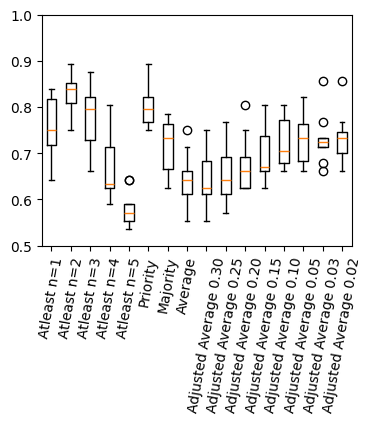

In [33]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.boxplot(accuracies.values())
ax.set_xticklabels(accuracies.keys())
plt.xticks(rotation=80)
plt.ylim([0.5, 1])
plt.show()

In [34]:
for name, acc in accuracies.items():
    print(name, np.median(acc), np.mean(acc))

Atleast n=1 0.75 0.7535714285714284
Atleast n=2 0.8392857142857143 0.8303571428571429
Atleast n=3 0.7946428571428572 0.7821428571428571
Atleast n=4 0.6339285714285714 0.6696428571428572
Atleast n=5 0.5714285714285714 0.5785714285714286
Priority 0.7946428571428572 0.8017857142857142
Majority 0.7321428571428571 0.7160714285714285
Average 0.6428571428571429 0.6446428571428571
Adjusted Average 0.30 0.625 0.6446428571428571
Adjusted Average 0.25 0.6428571428571428 0.6571428571428571
Adjusted Average 0.20 0.6607142857142857 0.675
Adjusted Average 0.15 0.6696428571428572 0.6982142857142857
Adjusted Average 0.10 0.7053571428571428 0.7232142857142858
Adjusted Average 0.05 0.7321428571428571 0.7285714285714286
Adjusted Average 0.03 0.7232142857142857 0.7303571428571429
Adjusted Average 0.02 0.7321428571428571 0.7339285714285715


In [37]:
my_dict = {}
for celltype in celltypes:
    try:
        dicts = []
        for i in range(10):
            fp = f"{PATH}/{celltype}/{i*100}.json"
            with open(fp, 'r') as file:
                data = json.load(file)
            dicts.append(data)
        accs = [d['accuracy'] for d in dicts]
        my_dict[celltype] = accs
    except:
        pass

sorted_dict = {k: v for k, v in sorted(my_dict.items(), key=lambda item: np.mean(item[1]))}

In [38]:
print_dict_comb = {}

for name, acc in sorted_dict.items():
    print_dict_comb[name] = acc

print_dict_comb['All'] = accuracies['Atleast n=2']

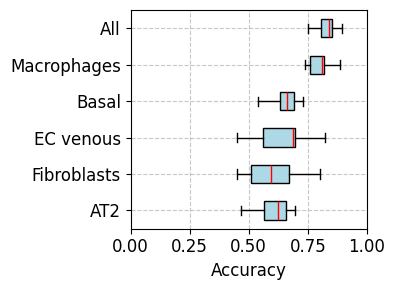

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the dictionary by the mean of the values
sorted_dict = {k: v for k, v in sorted(print_dict_comb.items(), key=lambda item: np.mean(item[1]))}

# Define figure size for better readability
fig, ax = plt.subplots(figsize=(4, 3))

# Create a horizontal box plot with sorted values
ax.boxplot(print_dict_comb.values(), vert=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           medianprops=dict(color='red'))

# Set y-axis labels with sorted keys
ax.set_yticklabels(print_dict_comb.keys(), fontsize=12)

# Set x-axis label with larger font size
ax.set_xlabel('Accuracy', fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase tick label size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.xlim([0, 1])

# Tight layout for better spacing
plt.tight_layout()

plt.savefig('accuracy_unsupervised.svg')

# Show the plot
plt.show()
